In [2]:
import json 
from tqdm import tqdm
import cv2
import os # For directory listing

# Maing dependency is pytorch
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
from torchvision import transforms
from torch.utils.data.dataloader import default_collate

# For visualization
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import hiddenlayer as hl

# Usual math
import numpy

# Progress
from tqdm import tqdm

# Model evaluation
from sklearn.neighbors import KNeighborsClassifier

from sklearn.manifold import TSNE

# Opening JSON file
url = 'https://data.bris.ac.uk/datasets/4vnrca7qw1642qlwxjadp87h7/Sub-levels/Detection_and_localisation/Train/images/train'
with open('utils/instances_train.json') as f:
    data = json.load(f)

In [3]:
import os

fileList = []
annotationList = []
for image in tqdm(data['images']):
    imageURL = '{}/{}'.format(url, image['file_name'])
    imageAnnotation = '{}/{}'.format(url, image['file_name'].replace('.jpg', '.xml'))
    fileList.append(imageURL)
    annotationList.append(imageAnnotation)

100%|██████████| 7248/7248 [00:00<00:00, 745361.53it/s]


In [3]:
import sys
import threading, queue
import urllib

class Downloader(threading.Thread):
    def __init__(self, queue, destination, pbar):
        super(Downloader, self).__init__()
        self.queue = queue
        self.destination = destination
        self.pbar = pbar

    def run(self):
        while True:
            download_url = queue.get()
            save_as = '{}/{}'.format(self.destination, os.path.basename(download_url))
            # sentinal
            if not download_url:
                return
            try:
                urllib.request.urlretrieve(download_url, filename=save_as)
                self.queue.task_done()
                self.pbar.update()
            except ValueError:
                self.queue.task_done()
                self.pbar.update()
                continue


queue = queue.Queue()
threads = []
with tqdm(len(fileList), position=0) as pbar:
    for i in range(8):
        threads.append(Downloader(queue, './download', pbar))
        threads[-1].start()

    for line in fileList:
        url = line.strip()
        queue.put((url))
    queue.join()
    print(queue.empty())

12234it [19:15,  9.43it/s]Exception in thread Thread-9:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/urllib/request.py", line 1354, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/http/client.py", line 1256, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/http/client.py", line 1302, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/http/client.py", line 1251, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/http/client.py", line 1011, in _send_output
    self.send(msg)
  File "/opt/homebrew/

KeyboardInterrupt: 

In [6]:
class ResNetMod(nn.Module):
    def __init__(self, numClasses, embeddingSize=128):
        """Initialize the model

        Parameters
        ----------
        numClasses : Int
            Number of classes (or individuals in a dataset)
        embeddingSize : Int, optional
            Size of the final embedding used differentiate individuals

        Returns
        -------
        A ResNetMod class instance
        """
        super(ResNetMod, self).__init__()

        # We create a resnet50 block and load imagenet weight into it
        self.backbone = models.resnet50(pretrained=True)
        imagenetWeights = model_zoo.load_url(
            "https://download.pytorch.org/models/resnet50-19c8e357.pth"
        )
        self.backbone.load_state_dict(imagenetWeights)

        # These layers are trained again, bias is set to true.
        self.backbone.fc = nn.Linear(2048, 1000)
        self.relu = nn.ReLU(inplace=True)
        self.embedding = nn.Linear(1000, embeddingSize)
        self.softmax = nn.Linear(1000, numClasses)

    def forwardOnce(self, x):
        """Forward through the network once

        Parameters
        ----------
        x : Input image to embed
            [Batch Size, Channel, Width, Height]

        Returns
        -------
        Embedding
            [Batch Size, 128]
        Softmax
            [Batch Size, Num Classes]
        """

        # Conv1 -> Relu(bn1) -> maxpool
        x = self.backbone.maxpool(
            self.backbone.relu(self.backbone.bn1(self.backbone.conv1(x)))
        )
        # avgpool(Layer 1 -> Layer 2 -> Layer 3 -> Layer 4)
        x = self.backbone.avgpool(
            self.backbone.layer4(
                self.backbone.layer3(self.backbone.layer2(self.backbone.layer1(x)))
            )
        )
        # Relu(FC)
        x = self.relu(self.backbone.fc(x.view(x.size(0), -1)))
        return self.embedding(x), self.softmax(x)

    def forward(self, anchor, negative=None, positive=None):
        """Forward the network

        Parameters
        ----------
        anchor : Input image to embed
            [Batch Size, Channel, Width, Height]
        negative : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss
        positive : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss

        Returns
        -------
        list
            Embeddings and softmax ouputs for negative, anchor,
            and postive triplets in case nagative and postive
            image inputs are provided. Otherwise, returns a
            single embedding and softmax output.
        """
        if (negative != None) & (positive != None):
            negativeEMBD, negativeSMax = self.forwardOnce(negative)
            anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            positiveEMBD, positiveSMax = self.forwardOnce(positive)
            return (
                negativeEMBD,
                anchorEMBD,
                positiveEMBD,
                torch.cat((negativeSMax, anchorSMax, positiveSMax), 0),
            )
        else:
            anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            return anchorEMBD, anchorSMax

    def __repr__(self):
        summary = f"{self.backbone.conv1.__repr__()} \n{self.backbone.bn1.__repr__()}"
        summary += "\nResnet Backbone: \n"
        layers = [
            self.backbone.layer1,
            self.backbone.layer2,
            self.backbone.layer3,
            self.backbone.layer4,
        ]
        for layer in layers:
            parameters = list(layer.named_parameters())
            summary += (
                f"\t ⎣ Input: {list(parameters[0][1].size())}"
                + f" -> Output: {list(parameters[-1][1].size())} ↩\n"
            )
        summary += self.backbone.fc.__repr__()
        summary += "\nOutput 1: " + self.embedding.__repr__()
        summary += "\nOutput 2: " + self.softmax.__repr__()
        return summary


In [33]:
import math
import xml.etree.ElementTree as ET
import numpy


def readRotatedXMLAnnotation(filepath):
    """Read rotated annotation in VOC format into a dict"""

    # Load the XML
    tree = ET.parse(filepath)

    # Which jpg file is this label pointing to
    image_fp = tree.find("filename").text + ".jpg"

    # Dictionary object for this annotation file
    annotation = {}

    # List of cow objects in this annotation file
    objects = []

    # The list of heads in this annotation file
    heads = []

    # First, find the head centres
    for obj in tree.findall("object"):
        # Only look at the head objects
        if obj.find("name").text == "head":
            head = {}

            # Get the head direction centre (just take the first point)
            # as a non-rotated bounding box
            try:
                head["cx"] = float(obj.find("bndbox").find("xmin").text)
                head["cy"] = float(obj.find("bndbox").find("ymin").text)
            except Exception as e1:
                # Failing that, try finding it as a rotated bbox
                try:
                    head["cx"] = float(obj.find("robndbox").find("cx").text)
                    head["cy"] = float(obj.find("robndbox").find("cy").text)
                except Exception as e2:
                    print(f"Couldn't find head element in {filepath}")
                    raise e2

            # Add it the list
            heads.append(head)

    # Loop over all the objects contained in the file
    for obj in tree.findall("object"):
        # Only look at cow objects
        if obj.find("name").text == "cow":
            # The cow dictionary object
            cow = {}

            # Get the values of the rotated bounding box
            try:
                cow["cx"] = float(obj.find("robndbox").find("cx").text)
                cow["cy"] = float(obj.find("robndbox").find("cy").text)
                cow["w"] = float(obj.find("robndbox").find("w").text)
                cow["h"] = float(obj.find("robndbox").find("h").text)
                cow["angle"] = float(obj.find("robndbox").find("angle").text)
            except Exception as e:
                print(f"Couldn't find cow robndbox element in {filepath}")
                raise e

            # Try and get a score (it may not exist)
            try:
                cow["score"] = float(obj.find("score").text)
            except Exception as e:
                pass

            # Normalise the angle
            # if cow['angle'] > math.pi: cow['angle'] -= math.pi
            # if cow['angle'] < -math.pi: cow['angle'] += math.pi

            # Always have the longest dimension as the height (may need swapping)
            # and adjust the angle for this
            if cow["w"] > cow["h"]:
                cow["h"], cow["w"] = cow["w"], cow["h"]
                cow["angle"] -= math.pi / 2
                if cow["angle"] < 0:
                    cow["angle"] += 2 * math.pi

            # Let's adjust the angle based on the direction of the head
            satisfied = False
            for head in heads:
                # Find whether this is the correct head direction dictionary
                if (cow["w"] / 2) ** 2 > (head["cx"] - cow["cx"]) ** 2 + (
                    head["cy"] - cow["cy"]
                ) ** 2:
                    # Add info about the centre of the head direction
                    cow["head_cx"] = head["cx"]
                    cow["head_cy"] = head["cy"]

                    # Find the angle of the head relative to the cow centre, add an offset to end up with
                    # 0/pi being north
                    head_ang = math.atan2((head["cy"] - cow["cy"]), (head["cx"] - cow["cx"]))
                    head_ang = math.degrees(head_ang + math.pi / 2)

                    # Convert atan2 back to normal range from [0, 360]
                    head_ang = (head_ang + 360) % 360
                    head_ang = math.radians(head_ang)

                    # Find the difference between the directions
                    diff = abs(cow["angle"] - head_ang)

                    # Determine the closest angle in math.pi/2 sized steps
                    angles = numpy.asarray([0, math.pi / 2, math.pi, 3 * math.pi / 2, 2 * math.pi])
                    idx = (numpy.abs(angles - diff)).argmin()
                    closest = angles[idx]

                    # Act based on this
                    if closest == math.pi:
                        cow["angle"] += math.pi

                    # We can stop here
                    satisfied = True
                    break

            # We didn't find a head for this cow object, flag it to the user
            if not satisfied:
                print(f"Did not find corresponding head for file: {image_fp}")

            # Add this to the list of objects for this annotation
            objects.append(cow)

    # Add the objects and the filename this annotation refers to
    annotation["image_filename"] = image_fp
    annotation["objects"] = objects

    return annotation


def rotatedRectToPixels(r_rect):
    # Get the centre and width height
    cx = r_rect["cx"]
    cy = r_rect["cy"]
    w = r_rect["w"]
    h = r_rect["h"]

    # Get the angle
    ang = r_rect["angle"]

    # Find the hypotenuse (the same for all four corners)
    l = math.sqrt(pow(w / 2, 2) + pow(h / 2, 2))

    # Compute the different angles for the sides of the box
    a1 = ang + math.atan(h / float(w))
    a2 = ang - math.atan(h / float(w))

    # Compute the rotated points
    x1 = int(cx - l * math.cos(a1))
    y1 = int(cy - l * math.sin(a1))

    x2 = int(cx - l * math.cos(a2))
    y2 = int(cy - l * math.sin(a2))

    x3 = int(cx + l * math.cos(a2))
    y3 = int(cy + l * math.sin(a2))

    x4 = int(cx + l * math.cos(a1))
    y4 = int(cy + l * math.sin(a1))

    return ((x1, y1), (x2, y2), (x3, y3), (x4, y4))


def drawRotatedBbox(img, annotations, display=False, display_head=False):
    """Given an image, render a set of rotated annotations"""

    # Make a copy
    render_img = img.copy()
    # Loop over every object in this annotation
    for obj in annotations:
        # Get pixel coordinates of each corner
        ((x1, y1), (x2, y2), (x3, y3), (x4, y4)) = rotatedRectToPixels(obj)

        # Extract the annotation centrepoint
        cx = int(obj["cx"])
        cy = int(obj["cy"])

        # Render the box, centre, head direction and top left box corner
        cv2.circle(render_img, (cx, cy), 5, (255, 0, 0), 5)

        # Is there a Identity included, render it if so
        if "ID" in obj.keys():
            ID = str(obj["ID"]).zfill(3)
            cv2.putText(
                render_img,
                f"ID={ID}",
                (cx, cy - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 0, 0),
                2,
                cv2.LINE_AA,
            )

        # Head direction
        if display_head:
            cv2.circle(render_img, (int(obj["head_cx"]), int(obj["head_cy"])), 5, (0, 0, 255), 5)

        # Top of box (and therefore head direction)
        top_x = int((x1 + x2) / 2)
        top_y = int((y1 + y2) / 2)
        cv2.circle(render_img, (top_x, top_y), 5, (0, 255, 0), 5)

        contours = numpy.vstack([[[[x1, y1]], [[x2, y2]], [[x3, y3]], [[x4, y4]]]]).squeeze()
        x,y,w,h = cv2.boundingRect(contours)
        if w > h:
            h = w
        elif h > w:
            w = h
        cv2.rectangle(render_img,(x,y),(x+w,y+h),(0,255,0),2)

        # The box
        cv2.line(render_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.line(render_img, (x2, y2), (x4, y4), (255, 0, 0), 2)
        cv2.line(render_img, (x4, y4), (x3, y3), (255, 0, 0), 2)
        cv2.line(render_img, (x3, y3), (x1, y1), (255, 0, 0), 2)

    # Display if we're supposed to
    if display:
        cv2.imshow("Visualisation", render_img)
        cv2.waitKey(0)

    return render_img


def extractRotatedSubImage(image, r_rect):
    # Convert the rotated rectangle to four pixel coordinates
    ((x1, y1), (x2, y2), (x3, y3), (x4, y4)) = rotatedRectToPixels(r_rect)

    # If there isn't a head centre/direction given, infer it from the top of the box
    if "head_cx" not in r_rect.keys() and "head_cy" not in r_rect.keys():
        r_rect["head_cx"] = int((x1 + x2) / 2)
        r_rect["head_cy"] = int((y1 + y2) / 2)

    # Create a numpy array with these four points
    contours = numpy.array([[[x1, y1]], [[x2, y2]], [[x3, y3]], [[x4, y4]]])

    # Find the area that bounds those points in box form
    rect = cv2.minAreaRect(contours)
    box = cv2.boxPoints(rect)
    box = numpy.int0(box)

    # What are the dimensions of this box
    width = int(rect[1][0])
    height = int(rect[1][1])

    # Create the standardised point sets
    src_pts = box.astype("float32")
    dst_pts = numpy.array(
        [[0, height - 1], [0, 0], [width - 1, 0], [width - 1, height - 1]], dtype="float32"
    )

    # Find the transformation (rotation) between these sets of points
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # Warp the image according to this
    cropped = cv2.warpPerspective(image, M, (width, height))

    # Transform cow and head points according to the transformation
    t_centre = numpy.matmul(M, [[r_rect["cx"]], [r_rect["cy"]], [1]])
    t_head = numpy.matmul(M, [[r_rect["head_cx"]], [r_rect["head_cy"]], [1]])

    # Rotate the image by 90 degrees so the cow is always horizontal
    h, w = cropped.shape[:2]
    if h > w:
        # Rotate in varying amounts of 90 degrees depending on whether the
        # head centre is above or below the cow centre
        if t_head[1][0] > t_centre[1][0]:
            cropped = numpy.rot90(cropped)
        else:
            cropped = numpy.rot90(cropped, k=3)
    # The image is horizontal, but may need to be rotated by 180 so that the
    # cow always faces to the right
    elif t_head[0][0] < t_centre[0][0]:
        cropped = numpy.rot90(cropped, k=2)

    return cropped


In [8]:
model = ResNetMod(46)
model.load_state_dict(torch.load('models/RTLSL_67-33_98.2.pth', map_location=torch.device('cpu')))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Resnet Backbone: 
	 ⎣ Input: [64, 64, 1, 1] -> Output: [256] ↩
	 ⎣ Input: [128, 256, 1, 1] -> Output: [512] ↩
	 ⎣ Input: [256, 512, 1, 1] -> Output: [1024] ↩
	 ⎣ Input: [512, 1024, 1, 1] -> Output: [2048] ↩
Linear(in_features=2048, out_features=1000, bias=True)
Output 1: Linear(in_features=1000, out_features=128, bias=True)
Output 2: Linear(in_features=1000, out_features=46, bias=True)

In [38]:
from PIL import Image
import matplotlib

transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def loadResizeImage(cv2Image, size=(224, 224)):      
    # Load the image
    img = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    # Keep the original image size
    old_size = img.size
    # Compute resizing ratio
    ratio = float(size[0])/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # Actually resize it
    img = img.resize(new_size, Image.ANTIALIAS)
    # Paste into centre of black padded image
    new_img = Image.new("RGB", (size[0], size[1]))
    new_img.paste(img, ((size[0]-new_size[0])//2, (size[1]-new_size[1])//2))
    # Convert to numpy
    new_img = numpy.array(new_img, dtype=numpy.uint8)
    return new_img

sequence = ['00035.jpg','00036.jpg','00037.jpg','00038.jpg','00039.jpg','00040.jpg','00041.jpg','00042.jpg','00043.jpg','00044.jpg','00045.jpg','00046.jpg','00047.jpg','00048.jpg','00049.jpg','00050.jpg','00051.jpg','00052.jpg']
sequence.sort()
outputEMBDs = numpy.zeros((1, 128))
i=0
for image in sequence:
    imagePath, annotation = "download/{}".format(image), "download/{}".format(
        image.replace(".jpg", ".xml")
    )
    original = cv2.imread(imagePath)
    annotation = readRotatedXMLAnnotation(annotation)
    rgb = drawRotatedBbox(original, annotation["objects"])
    # plt.rcParams["figure.figsize"] = (20, 15)
    # plt.imshow(rgb)
    # plt.show()
    for obj in annotation["objects"]:
        cropped = extractRotatedSubImage(original, obj)
        matplotlib.image.imsave("output/{}_crop.png".format(i), cropped)
        # You may need to convert the color.
        cropped = loadResizeImage(cropped).transpose(2, 0, 1)
        img = transform(torch.from_numpy(cropped).float() / 255)
        embeddings, _ = model(img[None, :])
        embeddings = embeddings.data.cpu().numpy()
        outputEMBDs = numpy.concatenate((outputEMBDs, embeddings), axis=0)
        matplotlib.image.imsave("output/{}_tracklet.png".format(i), cropped.transpose(1, 2, 0))
        i+=1
        # plt.imshow(cropped.permute(1, 2, 0))
        # plt.show()
    # break


/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


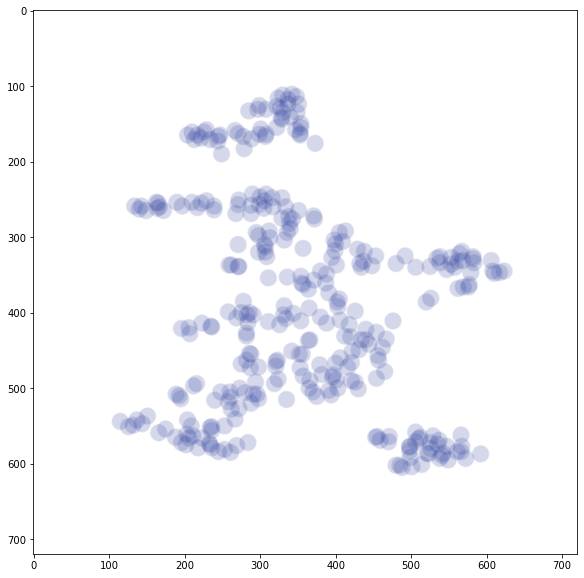

In [208]:
from PIL import Image
tSNE = TSNE(n_components=2, learning_rate='auto', perplexity=30)
# t-SNE reduction for all embeddings (train and test) for a consistent latent space
reduction = tSNE.fit_transform(outputEMBDs[1:])

def concat_images(imga, imgb):
    """
    Combines two color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = numpy.max([ha, hb])
    total_width = wa+wb
    new_img = numpy.zeros(shape=(max_height, total_width, 3))
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img

def makeViz(reduction):
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.ioff()
    fig, ax = plt.subplots(1, dpi=72)

    ax.scatter(
        reduction[:, 0], reduction[:, 1],
        s=500, alpha=0.2, edgecolor="#262626",
        linewidth=0.05, facecolor="#2e3f9f",
    )
    [ax.spines[spine].set_visible(False) for spine in ["top", "right", "bottom", "left"]]
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axis("tight")
    plt.close(fig)

    # from_canvas()
    fig.canvas.draw()
    image = numpy.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

image = makeViz(reduction)
plt.imshow(image)

In [221]:
import matplotlib

i = 0
j = 0
for image in sequence[52:]:
    imagePath, annotation = "download/{}".format(image), "download/{}".format(
        image.replace(".jpg", ".xml")
    )
    original = cv2.imread(imagePath)
    annotation = readRotatedXMLAnnotation(annotation)
    rgb = drawRotatedBbox(original, annotation["objects"])
    i += len(annotation["objects"])
    image = makeViz(reduction[:i-1])[:, :, :3]
    composite = concat_images(image, rgb) / 255
    matplotlib.image.imsave("output/{}.png".format(j), composite)
    j+=1

In [222]:
!cd output && rm -rf out.mp4 && ffmpeg -framerate 5 -i %d.png -c:v libx264 -pix_fmt yuv420p out.mp4

ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.1.0
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125573833/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125573833/_build_env/bin/pkg-config --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125573833/_build_env/bin/x86_64-apple-darwin13.4.0-cl